# 03 Prepare Economic Mobility Outcomes

**Project:** NORI  
**Author:** Yuseof J  
**Date:** 26/12/25  

### **Purpose**
Load the raw Opportunity Atlas data, filter for NYC tracts, and select outcome variables to be used in modeling. 

### **Inputs**
- `data/raw/opp_atlas/income_incarceration_from_low_income_household.csv`
- `data/processed/nyc_tracts.gpkg`

### **Outputs**
- `data/processed/opp_atlas_nyc.csv`
- `data/processed/nyc_tracts.gpkg (layer = econ_mobility_outcomes)`
  
--------------------------------------------------------------------------

### 0. Imports and Setup

In [25]:
# package imports
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path

# specify filepaths
path_opp_atlas = 'data/raw/opp_atlas/income_incarceration_from_low_income_household.csv'
path_nyc_tracts = 'data/processed/nyc_tracts.gpkg'
path_output_econ_mobility_outcomes = 'data/processed/outcomes_econ_mobility.csv'
output_gpkg_layer = 'econ_mobility_outcomes'

# final econ mobility output
econ_mobility_cols = ['kfr_pooled_pooled_p25']
econ_mobility_cols_rename = {'kfr_pooled_pooled_p25':'income_rank_children'}

# ensure cwd is project root for file paths to function properly
project_root = Path(os.getcwd())            # get current directory
while not (project_root / "data").exists(): # keep moving up until in parent
    project_root = project_root.parent
os.chdir(project_root)                      # switch to parent directory

A note on econ_mobility_cols (i.e. econ mobility outcomes of interest):

For the time being, we'll just use earnings of the children of low income parents, specifically variable *kfr_pooled_pooled_p25*.
From the opportunity atlas doumentation, this variable is: Mean household income rank for children whose parents were at the 25th percentile of the national income distribution. 

*NOTE*: The value of this variable is a rank, not a numerical value. Specifically, it is the percentile on the national income distribution that the children fall, specifically as a way to measure if children moved up the distribution from their parents (who were at the 25th percentile). 

### 1. Load Data

In [26]:
gdf_tracts_nyc = gpd.read_file(path_nyc_tracts, layer="tracts")
df_opp_atlas = pd.read_csv(path_opp_atlas)

### 2. EDA 

In [27]:
df_opp_atlas.columns.tolist()

['state',
 'county',
 'tract',
 'cz',
 'czname',
 'kfr_pooled_pooled_p25',
 'kfr_pooled_pooled_p25_se',
 'jail_pooled_pooled_p25',
 'jail_pooled_pooled_p25_se',
 'pooled_pooled_count',
 'kfr_black_pooled_p25',
 'kfr_black_pooled_p25_se',
 'kfr_hisp_pooled_p25',
 'kfr_hisp_pooled_p25_se',
 'kfr_white_pooled_p25',
 'kfr_white_pooled_p25_se',
 'jail_black_pooled_p25',
 'jail_black_pooled_p25_se',
 'jail_hisp_pooled_p25',
 'jail_hisp_pooled_p25_se',
 'jail_white_pooled_p25',
 'jail_white_pooled_p25_se',
 'white_pooled_count',
 'black_pooled_count',
 'hisp_pooled_count',
 'kfr_pooled_female_p25',
 'kfr_pooled_female_p25_se',
 'kfr_pooled_male_p25',
 'kfr_pooled_male_p25_se',
 'jail_pooled_female_p25',
 'jail_pooled_female_p25_se',
 'jail_pooled_male_p25',
 'jail_pooled_male_p25_se',
 'pooled_male_count',
 'pooled_female_count',
 'kfr_black_female_p25',
 'kfr_black_female_p25_se',
 'kfr_hisp_female_p25',
 'kfr_hisp_female_p25_se',
 'kfr_white_female_p25',
 'kfr_white_female_p25_se',
 'kfr_bl

In [28]:
df_opp_atlas.head()

,state,county,tract,cz,czname,kfr_pooled_pooled_p25,kfr_pooled_pooled_p25_se,jail_pooled_pooled_p25,jail_pooled_pooled_p25_se,pooled_pooled_count,...,jail_hisp_male_p25,jail_hisp_male_p25_se,jail_white_male_p25,jail_white_male_p25_se,white_male_count,black_male_count,hisp_male_count,white_female_count,black_female_count,hisp_female_count
0,1,1,20100,11101.0,Montgomery,0.367813,0.021693,0.031844,0.020345,228.14854,...,NaN,NaN,0.069903,0.035733,101.021520,NaN,NaN,89.647583,NaN,NaN
1,1,1,20200,11101.0,Montgomery,0.316781,0.014647,0.049013,0.019211,391.91345,...,NaN,NaN,0.002691,0.029357,32.695038,150.244080,NaN,46.506416,139.571000,NaN
2,1,1,20300,11101.0,Montgomery,0.373485,0.018376,0.030266,0.015061,394.79211,...,NaN,NaN,0.019237,0.013509,156.940720,50.579407,NaN,108.949490,49.571842,NaN
3,1,1,20400,11101.0,Montgomery,0.421511,0.019321,0.033916,0.014419,388.38309,...,NaN,NaN,0.018265,0.011083,181.365370,NaN,NaN,169.048230,NaN,NaN
4,1,1,20500,11101.0,Montgomery,0.433415,0.020093,0.013398,0.007040,419.08334,...,NaN,NaN,0.026169,0.014869,193.299360,28.388056,NaN,140.759220,21.622227,NaN


### 3. Data Processing and Filtering

Construct GEOID column for opp atlas

In [29]:
# ensure correct state fips format
df_opp_atlas['state'] = df_opp_atlas['state'].apply(lambda state: str(state).zfill(2))

# ensure correct county fips format
df_opp_atlas['county'] = df_opp_atlas['county'].apply(lambda county: str(county).zfill(3))

# ensure correct tract fips format
df_opp_atlas['tract'] = df_opp_atlas['tract'].apply(lambda tract: str(tract).zfill(6))

df_opp_atlas['GEOID'] = df_opp_atlas.state + df_opp_atlas.county + df_opp_atlas.tract

In [30]:
df_opp_atlas.GEOID.head()

0    01001020100
1    01001020200
2    01001020300
3    01001020400
4    01001020500
Name: GEOID, dtype: object

Select economic mobility outcomes of interest

In [31]:
# select columns
df_opp_atlas = df_opp_atlas[['GEOID'] + econ_mobility_cols]

Merge NYC Tracts with Opp Atlas

In [32]:
# ensure matching dtypes for join
gdf_tracts_nyc.GEOID = gdf_tracts_nyc.GEOID.astype(int)
df_opp_atlas.GEOID = df_opp_atlas.GEOID.astype(int)

# join on tract ID to get econ mobility outcomes for NYC tracts
gdf_tracts_nyc_econ_mobility = gdf_tracts_nyc.merge(df_opp_atlas,
                                                    how='left',
                                                    on='GEOID')
# create a seperate mobility outcomes csv for modeling
df_econ_mobility_outcomes_nyc = gdf_tracts_nyc_econ_mobility[df_opp_atlas.columns].copy()

In [33]:
# inspect tract coverage (%)
for col in econ_mobility_cols:
    tract_coverage = (df_econ_mobility_outcomes_nyc[col].notna().sum() / len(df_econ_mobility_outcomes_nyc)) * 100
    print(f"Found {col} data for {int(tract_coverage)}% of NYC tracts")

Found kfr_pooled_pooled_p25 data for 84% of NYC tracts


Distribution of Econ Mobility Outcomes (NYC)

array([[<Axes: title={'center': 'kfr_pooled_pooled_p25'}>]], dtype=object)

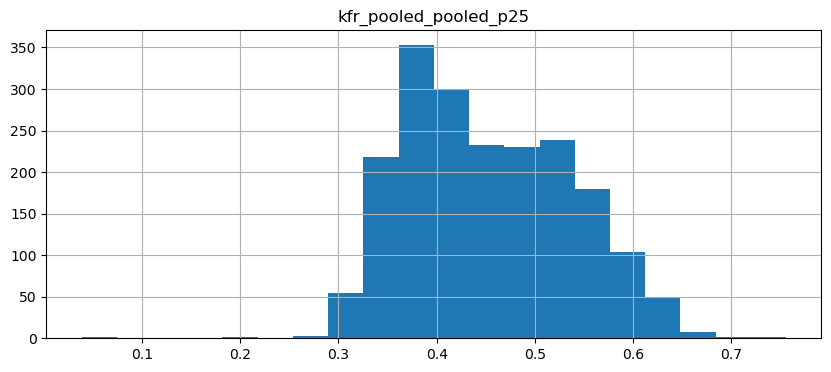

In [34]:
df_econ_mobility_outcomes_nyc[econ_mobility_cols].hist(bins=20, figsize=(10,4))

### 5. Save Data

In [36]:
# rename columns for legibility
df_econ_mobility_outcomes_nyc.rename(columns=econ_mobility_cols_rename, inplace=True)
gdf_tracts_nyc_econ_mobility.rename(columns=econ_mobility_cols_rename, inplace=True)

# save econ mobility outcomes for modeling
df_econ_mobility_outcomes_nyc.to_csv(path_output_econ_mobility_outcomes, index=False)

# also save outcomes to nyc tracts gpkg as new layer 
gdf_tracts_nyc_econ_mobility.to_file(path_nyc_tracts, layer=output_gpkg_layer)